In [24]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

# Data Preprocessing
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences

# Models
from keras import Model
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, LambdaCallback
from keras.layers import (Input, Embedding, Dropout, LSTM, Conv2D, MaxPool2D,
                          Dense, Activation, Reshape, Flatten, TimeDistributed)
from keras.optimizers import Adam, RMSprop
from keras.utils import plot_model

In [2]:
import keras.backend as K
K.tensorflow_backend._get_available_gpus()

[]

***

In [3]:
from utils.data import PATH_TO_DATA, GUIS_CODE, GUIS_SKETCH
from utils.data.image import get_preprocessed_img
from utils.data.sequence import tokenize_dsl_code
from utils.data.sets import (get_sketch_id_code_pair, init_sketch_id_code_map,
                             load_vocabulary, init_word2idx, init_idx2word)

***

In [4]:
demo_sketch_id = '00150311-A7AE-4804-8B7D-9273687B4FC0'

### Init Sketch to DSL Code map

In [5]:
sketch_id_code_map = init_sketch_id_code_map(GUIS_CODE)
print(sketch_id_code_map[demo_sketch_id])

header {
btn-inactive, btn-inactive, btn-inactive, btn-inactive
}
row {
single {
small-title, text, btn-orange
}
}
row {
double {
small-title, text, btn-orange
}
double {
small-title, text, btn-orange
}
}
row {
double {
small-title, text, btn-orange
}
double {
small-title, text, btn-orange
}
}



### Load / Show the Sketch

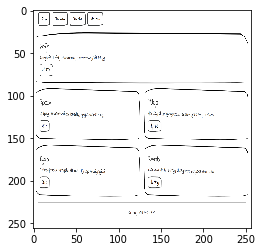

In [6]:
image = get_preprocessed_img(PATH_TO_DATA+demo_sketch_id+'.png')
plt.imshow(image);

***

## Create a Vocabulary

In [7]:
vocabulary = load_vocabulary('../vocabulary.txt')

In [8]:
len(vocabulary)

18

### Word2Idx, Idx2Word maps

In [9]:
word2idx = init_word2idx(vocabulary)
idx2word = init_idx2word(vocabulary)

In [10]:
word2idx

{'0': 0,
 ',': 1,
 '{': 2,
 '}': 3,
 'small-title': 4,
 'text': 5,
 'quadruple': 6,
 'row': 7,
 'btn-inactive': 8,
 'btn-orange': 9,
 'btn-green': 10,
 'btn-red': 11,
 'double': 12,
 '<START>': 13,
 'header': 14,
 'btn-active': 15,
 '<END>': 16,
 'single': 17}

In [11]:
idx2word

{0: '0',
 1: ',',
 2: '{',
 3: '}',
 4: 'small-title',
 5: 'text',
 6: 'quadruple',
 7: 'row',
 8: 'btn-inactive',
 9: 'btn-orange',
 10: 'btn-green',
 11: 'btn-red',
 12: 'double',
 13: '<START>',
 14: 'header',
 15: 'btn-active',
 16: '<END>',
 17: 'single'}

***

## Max DSL Code Length

In [12]:
print('Total number of DSL Codes: {}'.format(len(sketch_id_code_map.values())))

Total number of DSL Codes: 1700


In [13]:
longets_code = max(
    sketch_id_code_map.values(), key=lambda x: len(tokenize_dsl_code(x)))

print('Longes code:')
print('=' * 30)
print()
print(longets_code)

Longes code:

header {
btn-inactive, btn-inactive, btn-inactive, btn-inactive
}
row {
quadruple {
small-title, text, btn-orange
}
quadruple {
small-title, text, btn-orange
}
quadruple {
small-title, text, btn-orange
}
quadruple {
small-title, text, btn-orange
}
}
row {
quadruple {
small-title, text, btn-orange
}
quadruple {
small-title, text, btn-orange
}
quadruple {
small-title, text, btn-orange
}
quadruple {
small-title, text, btn-orange
}
}
row {
quadruple {
small-title, text, btn-orange
}
quadruple {
small-title, text, btn-orange
}
quadruple {
small-title, text, btn-orange
}
quadruple {
small-title, text, btn-orange
}
}



In [14]:
max_code_length = len(tokenize_dsl_code(longets_code)) + 2

print('Max DSL Code Length: {}'.format(max_code_length))

Max DSL Code Length: 117


In [15]:
max_code_length = 150

***

## Train/Dev/Test split

In [16]:
len(sketch_id_code_map)

1700

In [17]:
SPLIT = (.8, .1, .1)

In [18]:
items = list(sketch_id_code_map.items())
total_num = len(items)

borders = (
    int(total_num * SPLIT[0]),
    int(total_num * SPLIT[0]) + int(total_num * SPLIT[1]),
    int(total_num * SPLIT[0]) + int(total_num * SPLIT[1]) + int(
        total_num * SPLIT[2]),
)

train_sketch_id_code_map = dict(items[0:borders[0]])
dev_sketch_id_code_map = dict(items[borders[0]:borders[1]])
test_sketch_id_code_map = dict(items[borders[1]:borders[2]])

In [19]:
assert len(train_sketch_id_code_map) + len(dev_sketch_id_code_map) + len(
    test_sketch_id_code_map) == len(sketch_id_code_map)

In [20]:
print('Train Set size: {}'.format(len(train_sketch_id_code_map)))
print('Dev Set size: {}'.format(len(dev_sketch_id_code_map)))
print('Test Set size: {}'.format(len(test_sketch_id_code_map)))

Train Set size: 1360
Dev Set size: 170
Test Set size: 170


***

## Data Generator

In [21]:
# data generator, intended to be used in a call to model.fit_generator()


def data_generator(sketch_id_code_set, word2idx, batch_size, maxlen=max_code_length):
    X_img = np.zeros((batch_size, 256, 256, 3))
    X_seq = []
    Y_seq = []
    n = 0

    # loop for ever over images
    while True:
        for sketch_id, code in sketch_id_code_set.items():
            # load sketch
            sketch = get_preprocessed_img(PATH_TO_DATA+sketch_id+'.png')
            X_img[n] = sketch

            # encode the sequence
            y_seq = [word2idx[word] for word in tokenize_dsl_code(code)
                     ] + [word2idx['<END>']]
            x_seq = [word2idx['<START>']] + y_seq[:-1]

            Y_seq.append(y_seq)
            X_seq.append(x_seq)

            n += 1
            # yield the batch data
            if n == batch_size:
                X_seq = pad_sequences(X_seq, maxlen=maxlen, padding='post')
                Y_seq = pad_sequences(Y_seq, maxlen=maxlen, padding='post')

                # One-hot
                Y_seq = [[
                    to_categorical(idx, len(vocabulary)) for idx in sent
                ] for sent in Y_seq]

                yield [[X_img, X_seq], np.array(Y_seq)]

                X_img = np.zeros((batch_size, 256, 256, 3))
                X_seq = []
                Y_seq = []
                n = 0

***

In [22]:
EMBEDDING_DIM = 50
NUM_HIDDEN_NEURONS = 256

# Sketch Encoder (ConvNet)

In [25]:
img_in = Input((256, 256, 3), name='image_input')

x = Conv2D(32, (3, 3), activation='relu', padding='valid', name='conv_32_1')(img_in)
x = Conv2D(32, (3, 3), activation='relu', padding='valid', name='conv_32_2')(x)
x = MaxPool2D(pool_size=(2, 2), name='maxpool_1')(x)
x = Dropout(0.3, name='conv_dropout_1')(x)

x = Conv2D(64, (3, 3), activation='relu', padding='valid', name='conv_64_1')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='valid', name='conv_64_2')(x)
x = MaxPool2D(pool_size=(2, 2), name='maxpool_2')(x)
x = Dropout(0.3, name='conv_dropout_2')(x)

x = Conv2D(128, (3, 3), activation='relu', padding='valid', name='conv_128_1')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='valid', name='conv_128_2')(x)
x = MaxPool2D(pool_size=(2, 2), name='maxpool_3')(x)
x = Dropout(0.3, name='conv_dropout_3')(x)

x = Flatten(name='flatten')(x)

x = Dense(1024, activation='relu', name='dense_relu_1')(x)
x = Dropout(0.3, name='dense_dropout_1')(x)

x = Dense(EMBEDDING_DIM, activation='relu', name='dense_relu_2')(x)
x = Reshape((1, EMBEDDING_DIM), name='embedding_reshapor')(x)

sketch_encoder = Model(img_in, x, name='sketch_encoder')

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [26]:
plot_model(sketch_encoder, to_file='./model_plots/look_once/sketch_encoder.png', show_shapes=True, show_layer_names=True)

print(sketch_encoder.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_input (InputLayer)     (None, 256, 256, 3)       0         
_________________________________________________________________
conv_32_1 (Conv2D)           (None, 254, 254, 32)      896       
_________________________________________________________________
conv_32_2 (Conv2D)           (None, 252, 252, 32)      9248      
_________________________________________________________________
maxpool_1 (MaxPooling2D)     (None, 126, 126, 32)      0         
_________________________________________________________________
conv_dropout_1 (Dropout)     (None, 126, 126, 32)      0         
_________________________________________________________________
conv_64_1 (Conv2D)           (None, 124, 124, 64)      18496     
_________________________________________________________________
conv_64_2 (Conv2D)           (None, 122, 122, 64)      36928     
__________

***

# Sequence Decoder (LSTM)
<br>
A LSTM network

![LSTM_net](../img/LSTM.png)

In [27]:
# Sequence Input
seq_in = Input((max_code_length,), name='sequence_input')
sketch_emb_in = Input((1, EMBEDDING_DIM), name='sketch_emb_input')


# Embeddings
embeddings = Embedding(
    len(vocabulary),
    EMBEDDING_DIM,
    input_length=max_code_length,
    mask_zero=True,
    name='embeddings'
)
x = embeddings(seq_in)
    
# Dropout
embeddings_dropout = Dropout(0.3, name='embeddings_dropout')
x = embeddings_dropout(x)

# Sequence Decoder
lstm_decoder = LSTM(NUM_HIDDEN_NEURONS, return_sequences=True, return_state=True, name='lstm_decoder')

# Get the context from the Sketch
_, h_state, c_state = lstm_decoder(sketch_emb_in)

# Generate the code
x, _, _ = lstm_decoder(x, initial_state=[h_state, c_state])

# Dense -> Softmax
dense_decoder = TimeDistributed(Dense(len(vocabulary)), name='dense_decoder')
x = dense_decoder(x)
softmax_decoder = TimeDistributed(Activation('softmax'), name='softmax_decoder')
x = softmax_decoder(x)

sequence_decoder = Model(inputs=[seq_in, sketch_emb_in], outputs=x, name='sequence_decoder')

In [28]:
plot_model(sequence_decoder, to_file='./model_plots/look_once/sequence_decoder.png', show_shapes=True, show_layer_names=True)

print(sequence_decoder.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
sequence_input (InputLayer)     (None, 150)          0                                            
__________________________________________________________________________________________________
embeddings (Embedding)          (None, 150, 50)      900         sequence_input[0][0]             
__________________________________________________________________________________________________
sketch_emb_input (InputLayer)   (None, 1, 50)        0                                            
__________________________________________________________________________________________________
lstm_decoder (LSTM)             multiple             314368      sketch_emb_input[0][0]           
                                                                 embeddings_dropout[0][0]         
          

***

# Model

![NIC_model](../img/Model.png)

In [29]:
sketch_emb = sketch_encoder(img_in)
seq_out = sequence_decoder([seq_in, sketch_emb])

# Build the model
model = Model(inputs=[img_in, seq_in], outputs=seq_out, name='model')


### Visualize the model

In [30]:
plot_model(model, to_file='./model_plots/look_once/model.png', show_shapes=True, show_layer_names=True)

print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_input (InputLayer)        (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
sequence_input (InputLayer)     (None, 150)          0                                            
__________________________________________________________________________________________________
sketch_encoder (Model)          (None, 1, 50)        103099730   image_input[0][0]                
__________________________________________________________________________________________________
sequence_decoder (Model)        (None, 150, 18)      319894      sequence_input[0][0]             
                                                                 sketch_encoder[1][0]             
Total para

***

# Inference

![LSTM_sampling](../img/Sampling.png)

In [31]:
def init_inference_decoder():
    h_state_input = Input((NUM_HIDDEN_NEURONS, ), name='h_state_input')
    c_state_input = Input((NUM_HIDDEN_NEURONS, ), name='c_state_input')

    embedded_seq = embeddings(seq_in)
    embedded_seq = embeddings_dropout(embedded_seq)

    output_tokens, h_state, c_state = lstm_decoder(
        embedded_seq, initial_state=[h_state_input, c_state_input])
    output_tokens = dense_decoder(output_tokens)
    output_tokens = softmax_decoder(output_tokens)

    inference_decoder = Model([seq_in, h_state_input, c_state_input],
                              [output_tokens, h_state, c_state])

    return inference_decoder


def get_sketch_embedding(sketch):
    return sketch_encoder.predict(np.expand_dims(sketch, 0))


def get_initial_lstm_states(sketch):
    states_model = Model(sketch_emb_in, lstm_decoder(sketch_emb_in)[1:])
    sketch_emb = get_sketch_embedding(sketch)
    return states_model.predict(sketch_emb)


def greedy_search_inference(sketch):
    inference_decoder = init_inference_decoder()
    
    # Get the context of the Sketch
    states_values = get_initial_lstm_states(sketch)

    target_seq = np.zeros((1, max_code_length))
    target_seq[0, 0] = word2idx['<START>']

    stop_condition = False
    decoded_tokens = []

    while not stop_condition:
        output_tokens, h_state, c_state = inference_decoder.predict(
            [target_seq] + states_values)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, 0, :])
        sampled_word = idx2word[sampled_token_index]
        decoded_tokens.append(sampled_word)

        # Exit condition
        if (sampled_word == '<END>' or len(decoded_tokens) >= max_code_length):
            stop_condition = True

        target_seq = np.zeros((1, max_code_length))
        target_seq[0, 0] = sampled_token_index

        states_values = [h_state, c_state]

    return ' '.join(decoded_tokens)

In [32]:

greedy_search_inference(get_preprocessed_img(PATH_TO_DATA+demo_sketch_id+'.png'))

'row row row row row row row row row row row row row row row row row row row row row row row row row row row row row row row row row row row row row row row row row row row row row row row row row row row row row row row row row row row row row row row row row row row row row row row row row row row row row row row row row row row row row row row row row row row row row row row row row row row row row row row row row row row row row row row row row row row row row row row row row row row row row row row row row row row row row row row row row row row row row row row row row row row row row row'

***

## Run Train

### Callbacks

In [35]:
filepath="weights/weights-{epoch:02d}.hdf5"
checkpoint = ModelCheckpoint(filepath, verbose=True)

def on_epoch_end(epoch, logs):
    if epoch % 5 == 0:
        print()
        print('Sampled:')
        print('='*30)
        print(greedy_search_inference(get_preprocessed_img(
            PATH_TO_DATA+np.random.choice(list(dev_sketch_id_code_map.keys()))+'.png'
        )))
        print()
        print()

lambda_cb = LambdaCallback(on_epoch_end=on_epoch_end)

callbacks = [checkpoint, lambda_cb]

In [39]:
model.compile(RMSprop(0.0001, clipvalue=1.0), loss='categorical_crossentropy')

In [40]:
batch_size = 64
steps = len(train_sketch_id_code_map) // batch_size

model.fit_generator(
    data_generator(train_sketch_id_code_map, word2idx, batch_size),
    steps_per_epoch=steps,
    epochs=1000,
    verbose=True,
    callbacks=callbacks,
)

Epoch 1/1000
21/21 [==============================] - 50s 2s/step - loss: 0.0708

Epoch 00001: saving model to weights/weights-01.hdf5

Sampled:
header { btn-inactive , btn-inactive , btn-inactive , btn-inactive } row { quadruple { small-title , text , btn-orange } quadruple { small-title , text , btn-orange } quadruple { small-title , text , btn-orange } quadruple { small-title , text , btn-orange } } row { double { small-title , text , btn-orange } double { small-title , text , btn-orange } } row { single { small-title , text , btn-orange } } <END>


Epoch 2/1000
21/21 [==============================] - 39s 2s/step - loss: 0.0679

Epoch 00002: saving model to weights/weights-02.hdf5
Epoch 3/1000
21/21 [==============================] - 50s 2s/step - loss: 0.0670

Epoch 00003: saving model to weights/weights-03.hdf5
Epoch 4/1000
21/21 [==============================] - 50s 2s/step - loss: 0.0664

Epoch 00004: saving model to weights/weights-04.hdf5
Epoch 5/1000
21/21 [================

21/21 [==============================] - 38s 2s/step - loss: 0.0621

Epoch 00037: saving model to weights/weights-37.hdf5
Epoch 38/1000
21/21 [==============================] - 49s 2s/step - loss: 0.0620

Epoch 00038: saving model to weights/weights-38.hdf5
Epoch 39/1000
21/21 [==============================] - 49s 2s/step - loss: 0.0621

Epoch 00039: saving model to weights/weights-39.hdf5
Epoch 40/1000
21/21 [==============================] - 50s 2s/step - loss: 0.0620

Epoch 00040: saving model to weights/weights-40.hdf5
Epoch 41/1000
21/21 [==============================] - 50s 2s/step - loss: 0.0620

Epoch 00041: saving model to weights/weights-41.hdf5

Sampled:
header { btn-inactive , btn-inactive , btn-inactive , btn-inactive } row { double { small-title , text , btn-orange } double { small-title , text , btn-orange } } row { quadruple { small-title , text , btn-orange } quadruple { small-title , text , btn-orange } quadruple { small-title , text , btn-orange } quadruple { small

KeyboardInterrupt: 

***

## Dev

header { btn-inactive , btn-inactive , btn-inactive , btn-inactive , btn-inactive } row { quadruple { small-title , text , btn-orange } quadruple { small-title , text , btn-orange } quadruple { small-title , text , btn-orange } quadruple { small-title , text , btn-orange } } row { single { small-title , text , btn-orange } } row { double { small-title , text , btn-orange } double { small-title , text , btn-orange } } <END>


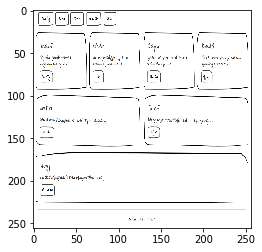

In [41]:
sketch_id = np.random.choice(list(dev_sketch_id_code_map.keys()))
sketch = get_preprocessed_img(PATH_TO_DATA+sketch_id+'.png')

plt.imshow(sketch);
print(greedy_search_inference(sketch))